# The Battle of Neighborhoods - A Family Business Moving to a New Location

## Objective

## Setting up the pre-requisites

Before we start work, let's install and import the required libraries and setup options that will help in later stages.

In [292]:
# Uncomment to install required packages

#!pip install beautifulsoup4
#!pip install lxml
#!pip install geopy
#!pip install geocoder
#!pip install folium

print('Installations done.')

Installations done.


In [358]:
# Importing necessary libraries

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium # map rendering library

# K-means for clustering 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For error handling, progress tracking and API throtling
from random import randint
from time import sleep
import sys
import logging

# For web scrapping and location retrieval
from bs4 import BeautifulSoup
import geocoder as gc # import geocoder
from geopy.geocoders import Nominatim # we could've used geocoder (above) as well

# JSON and HTML formatting
import pprint

print('Libraries imported.')

Libraries imported.


In [294]:
# Adjust options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# So that more data can be printed on a single line
pp = pprint.PrettyPrinter(width=120)

print('Options adjusted.')

Options adjusted.


In [295]:
def standardize_columns(columns):
    return columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

def fix_html_encoding(column):
    return column.str.encode(encoding="ascii", errors="ignore").str.decode(encoding="ascii", errors="ignore")

## Data Collection

Loading region-wise state list that was downloaded from https://github.com/cphalpert/census-regions

In [381]:
states = pd.read_csv('us census bureau regions and divisions.csv')
states.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [382]:
states.columns = standardize_columns(states.columns)

states.drop('division', axis=1, inplace=True)
states['region'].value_counts()

South        17
West         13
Midwest      12
Northeast     9
Name: region, dtype: int64

In [383]:
states=states[(states['region']=='Northeast') | (states['region']=='South') | (states['state']=='Alabama')].reset_index(drop=True)
states

,state,state_code,region
0,Alabama,AL,South
1,Arkansas,AR,South
2,Connecticut,CT,Northeast
3,District of Columbia,DC,South
4,Delaware,DE,South
5,Florida,FL,South
6,Georgia,GA,South
7,Kentucky,KY,South
8,Louisiana,LA,South
9,Massachusetts,MA,Northeast


Let's download the postal codes of Toronto city through the Wikipdia page, scrape using **BeautifulSoup** and create the DataFrame. _Ensure that all requirements from point 2 & 3 of the assignment are met here._

In [384]:
# Create request object, download page and read the desired table

from html import unescape

url_list = [
    'https://www.currentresults.com/Weather/US/average-annual-state-precipitation.php',
    'https://www.currentresults.com/Weather/US/average-snowfall-by-state.php',
    'https://www.currentresults.com/Weather/US/annual-average-humidity-by-state.php',
    'https://www.currentresults.com/Weather/US/average-annual-state-sunshine.php',
    'https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php'
]

weather=pd.DataFrame()
for url in url_list:
    table = pd.read_html(requests.get(url).text,)
    table = pd.concat([table[0], table[1], table[2]]).reset_index(drop=True)
    
    table.columns = standardize_columns(table.columns)
    table['state']=fix_html_encoding(table['state'])

    if weather.empty == True:
        weather=table
    else:
        weather=weather.merge(table, on='state', how='left')

weather.head()

,state,inches_x,milli­metres,rank_x,days,place_x,inches_y,cen­ti­me­tres,place_y,morn­ing,after­noon,place,%_sun,total_hours,clear_days,avg_°f,avg_°c,rank_y
0,Alabama,58.3,1480,4,0.8,Birming­ham,1.6,4.1,Birmingham,84,52,Birmingham,58,2641,99,62.8,17.1,7
1,Alaska,22.5,572,39,48.0,Anchor­age,74.5,189.2,Anchorage,77,64,Anchorage,41,2061,61,26.6,-3.0,50
2,Arizona,13.6,345,47,0.3,Tucson,0.3,0.8,Tucson,53,25,Tucson,85,3806,193,60.3,15.7,10
3,Arkansas,50.6,1284,8,3.8,Fort Smith,5.2,13.2,Fort Smith,85,49,Fort Smith,61,2771,123,60.4,15.8,9
4,California,22.2,563,40,0.0,San Diego,0.0,0.0,San Diego,76,62,San Diego,68,3055,146,59.4,15.2,12


In [385]:
weather=weather[weather.columns[~weather.columns.str.contains('place|rank|inches|°f')]]
weather.head(10)

,state,milli­metres,days,cen­ti­me­tres,morn­ing,after­noon,%_sun,total_hours,clear_days,avg_°c
0,Alabama,1480,0.8,4.1,84,52,58,2641,99,17.1
1,Alaska,572,48.0,189.2,77,64,41,2061,61,-3.0
2,Arizona,345,0.3,0.8,53,25,85,3806,193,15.7
3,Arkansas,1284,3.8,13.2,85,49,61,2771,123,15.8
4,California,563,0.0,0.0,76,62,68,3055,146,15.2
5,Colorado,405,19.1,48.5,60,35,71,3204,136,7.3
6,Connecticut,1279,20.1,102.9,79,52,56,2585,82,9.4
7,Delaware,1160,11.8,51.3,79,54,–,–,97,12.9
8,Florida,1385,0.0,0.0,87,57,66,2927,101,21.5
9,Georgia,1287,0.7,1.8,86,50,66,2986,112,17.5


In [386]:
#%%time

home_values = pd.read_csv('unites-states-home-values.csv', sep=';', usecols=['State', 'Home value ($ per m2)'])
home_values.columns = standardize_columns(home_values.columns)
home_values.head()

,state,home_value_$_per_m2
0,NY,89
1,NY,130
2,NY,65
3,WV,28
4,WV,43


In [387]:
home_values=home_values.groupby('state').mean().reset_index().rename(columns={'state':'state_code', 'home_value_$_per_m2':'home_value'})
home_values.head()

,state_code,home_value
0,AK,199.971200
1,AL,86.419470
2,AR,74.793365
3,AZ,229.199801
4,CA,526.929550


In [396]:
states_data=states.merge(weather, on='state', how='left').merge(home_values, on='state_code', how='left')
states_data

,state,state_code,region,milli­metres,days,cen­ti­me­tres,morn­ing,after­noon,%_sun,total_hours,clear_days,avg_°c,home_value
0,Alabama,AL,South,1480.0,0.8,4.1,84.0,52.0,58,2641,99.0,17.1,86.419470
1,Arkansas,AR,South,1284.0,3.8,13.2,85.0,49.0,61,2771,123.0,15.8,74.793365
2,Connecticut,CT,Northeast,1279.0,20.1,102.9,79.0,52.0,56,2585,82.0,9.4,230.990937
3,District of Columbia,DC,South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,536.031359
4,Delaware,DE,South,1160.0,11.8,51.3,79.0,54.0,–,–,97.0,12.9,390.033860
5,Florida,FL,South,1385.0,0.0,0.0,87.0,57.0,66,2927,101.0,21.5,320.272950
6,Georgia,GA,South,1287.0,0.7,1.8,86.0,50.0,66,2986,112.0,17.5,119.665394
7,Kentucky,KY,South,1242.0,11.8,31.8,79.0,55.0,56,2514,93.0,13.1,79.535841
8,Louisiana,LA,South,1528.0,0.1,0.0,87.0,61.0,57,2649,101.0,19.1,210.489133
9,Massachusetts,MA,Northeast,1211.0,22.4,111.3,75.0,59.0,58,2634,98.0,8.8,285.895846


In [398]:
states_data.columns = fix_html_encoding(states_data.columns)
states_data.head()

,state,state_code,region,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
0,Alabama,AL,South,1480.0,0.8,4.1,84.0,52.0,58,2641,99.0,17.1,86.419470
1,Arkansas,AR,South,1284.0,3.8,13.2,85.0,49.0,61,2771,123.0,15.8,74.793365
2,Connecticut,CT,Northeast,1279.0,20.1,102.9,79.0,52.0,56,2585,82.0,9.4,230.990937
3,District of Columbia,DC,South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,536.031359
4,Delaware,DE,South,1160.0,11.8,51.3,79.0,54.0,–,–,97.0,12.9,390.033860


In [399]:
states_data.dtypes

state           object
state_code      object
region          object
millimetres    float64
days           float64
centimetres    float64
morning        float64
afternoon      float64
%_sun           object
total_hours     object
clear_days     float64
avg_c          float64
home_value     float64
dtype: object

In [400]:
states_data[['millimetres', 'days', 'centimetres',
       'morning', 'afternoon', '%_sun', 'total_hours', 'clear_days', 'avg_c',
       'home_value']] = states_data[['millimetres', 'days', 'centimetres',
       'morning', 'afternoon', '%_sun', 'total_hours', 'clear_days', 'avg_c',
       'home_value']].apply(pd.to_numeric, errors='coerce')

states_data.dtypes

state           object
state_code      object
region          object
millimetres    float64
days           float64
centimetres    float64
morning        float64
afternoon      float64
%_sun          float64
total_hours    float64
clear_days     float64
avg_c          float64
home_value     float64
dtype: object

In [401]:
print (states_data.shape)
states_data=states_data.dropna()
print (states_data.shape)
states_data

(26, 13)
(23, 13)


,state,state_code,region,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
0,Alabama,AL,South,1480.0,0.8,4.1,84.0,52.0,58.0,2641.0,99.0,17.1,86.419470
1,Arkansas,AR,South,1284.0,3.8,13.2,85.0,49.0,61.0,2771.0,123.0,15.8,74.793365
2,Connecticut,CT,Northeast,1279.0,20.1,102.9,79.0,52.0,56.0,2585.0,82.0,9.4,230.990937
5,Florida,FL,South,1385.0,0.0,0.0,87.0,57.0,66.0,2927.0,101.0,21.5,320.272950
6,Georgia,GA,South,1287.0,0.7,1.8,86.0,50.0,66.0,2986.0,112.0,17.5,119.665394
7,Kentucky,KY,South,1242.0,11.8,31.8,79.0,55.0,56.0,2514.0,93.0,13.1,79.535841
8,Louisiana,LA,South,1528.0,0.1,0.0,87.0,61.0,57.0,2649.0,101.0,19.1,210.489133
9,Massachusetts,MA,Northeast,1211.0,22.4,111.3,75.0,59.0,58.0,2634.0,98.0,8.8,285.895846
10,Maryland,MD,South,1131.0,9.6,51.3,77.0,52.0,57.0,2582.0,105.0,12.3,267.582460
11,Maine,ME,Northeast,1072.0,27.8,157.0,82.0,61.0,57.0,2513.0,101.0,5.0,320.398009


In [402]:
states_data.describe()

,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,1211.130435,13.847826,62.460870,82.217391,54.217391,58.521739,2649.130435,100.695652,13.060870,219.671588
std,183.850064,17.447997,80.619323,4.022172,4.155572,5.106765,215.433876,18.692329,4.602543,138.274729
min,734.000000,0.000000,0.000000,75.000000,48.000000,46.000000,2120.000000,58.000000,5.000000,73.488263
25%,1096.000000,1.050000,3.950000,79.000000,52.000000,56.000000,2516.500000,93.500000,9.350000,109.318054
50%,1218.000000,6.200000,26.200000,83.000000,53.000000,58.000000,2634.000000,101.000000,13.100000,201.206808
75%,1285.500000,19.750000,94.400000,84.500000,57.500000,61.000000,2798.500000,110.000000,17.000000,279.331649
max,1528.000000,66.400000,314.500000,91.000000,61.000000,68.000000,3089.000000,139.000000,21.500000,673.798746


In [403]:
#states_data.to_csv('States_Data.csv', header=True, index=False)
#states_data = pd.read_csv('States_Data.csv') 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026B2C5A7B08>,
      dtype=object)

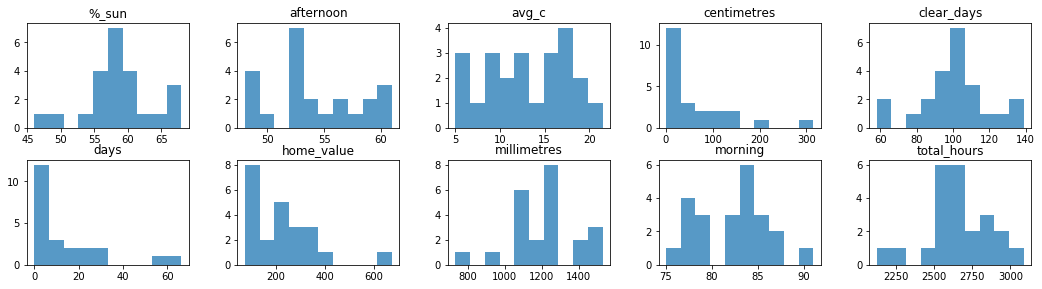

In [404]:
states_data.hist(figsize=(18,12), bins=10, grid=False, alpha=0.75, layout=(5,5))

In [448]:
X = states_data.values[:,3:12]
X

array([[1480.0, 0.8, 4.1, 84.0, 52.0, 58.0, 2641.0, 99.0, 17.1],
       [1284.0, 3.8, 13.2, 85.0, 49.0, 61.0, 2771.0, 123.0, 15.8],
       [1279.0, 20.1, 102.9, 79.0, 52.0, 56.0, 2585.0, 82.0, 9.4],
       [1385.0, 0.0, 0.0, 87.0, 57.0, 66.0, 2927.0, 101.0, 21.5],
       [1287.0, 0.7, 1.8, 86.0, 50.0, 66.0, 2986.0, 112.0, 17.5],
       [1242.0, 11.8, 31.8, 79.0, 55.0, 56.0, 2514.0, 93.0, 13.1],
       [1528.0, 0.1, 0.0, 87.0, 61.0, 57.0, 2649.0, 101.0, 19.1],
       [1211.0, 22.4, 111.3, 75.0, 59.0, 58.0, 2634.0, 98.0, 8.8],
       [1131.0, 9.6, 51.3, 77.0, 52.0, 57.0, 2582.0, 105.0, 12.3],
       [1072.0, 27.8, 157.0, 82.0, 61.0, 57.0, 2513.0, 101.0, 5.0],
       [1499.0, 0.6, 2.3, 91.0, 54.0, 61.0, 2720.0, 111.0, 17.4],
       [1279.0, 3.9, 19.3, 83.0, 52.0, 60.0, 2651.0, 109.0, 15.0],
       [1103.0, 29.8, 154.4, 84.0, 53.0, 54.0, 2519.0, 90.0, 6.6],
       [1196.0, 8.7, 41.9, 83.0, 59.0, 56.0, 2499.0, 94.0, 11.5],
       [1062.0, 66.4, 314.5, 82.0, 61.0, 46.0, 2120.0, 63.0, 7.4],
 

In [449]:
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 1.49530725e+00, -7.64619118e-01, -7.40176318e-01,
         4.53156263e-01, -5.45587179e-01, -1.04462422e-01,
        -3.85880074e-02, -9.27525660e-02,  8.97310253e-01],
       [ 4.05261149e-01, -5.88815322e-01, -6.24763293e-01,
         7.07365874e-01, -1.28373454e+00,  4.96196506e-01,
         5.78407405e-01,  1.22005298e+00,  6.08509644e-01],
       [ 3.77453851e-01,  3.66385302e-01,  5.12879381e-01,
        -8.17891792e-01, -5.45587179e-01, -5.04901708e-01,
        -3.04370646e-01, -1.02265650e+00, -8.13277969e-01],
       [ 9.66968577e-01, -8.11500130e-01, -7.92175593e-01,
         1.21578510e+00,  6.84658420e-01,  1.49729472e+00,
         1.31880190e+00,  1.66478965e-02,  1.87478924e+00],
       [ 4.21945528e-01, -7.70479244e-01, -7.69346643e-01,
         9.61575485e-01, -1.03768542e+00,  1.49729472e+00,
         1.59882289e+00,  6.18350440e-01,  9.86171979e-01],
       [ 1.71679842e-01, -1.20005200e-01, -3.88864143e-01,
        -8.17891792e-01,  1.92560181e-01, -5.049017

In [450]:
Clus_dataSet.shape

(23, 9)

In [451]:
Sum_of_squared_distances = []
labels=[]
K = range(1,15)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(Clus_dataSet)
    Sum_of_squared_distances.append(k_means.inertia_)
    labels.append(k_means.labels_)

labels

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]),
 array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        0]),
 array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1,
        2]),
 array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 3, 2, 0, 0, 1, 1, 2, 1,
        3]),
 array([2, 4, 1, 2, 4, 1, 2, 1, 1, 1, 2, 4, 1, 1, 3, 0, 1, 1, 4, 2, 0, 4,
        3]),
 array([1, 1, 3, 5, 1, 3, 5, 3, 3, 0, 5, 1, 0, 3, 2, 4, 3, 3, 1, 1, 4, 1,
        2]),
 array([2, 5, 3, 4, 5, 3, 4, 3, 3, 6, 4, 2, 6, 3, 1, 0, 3, 3, 5, 2, 0, 5,
        1]),
 array([1, 4, 5, 7, 4, 0, 7, 5, 0, 6, 7, 1, 6, 0, 3, 2, 5, 5, 4, 1, 2, 4,
        3]),
 array([6, 1, 0, 3, 1, 0, 8, 0, 0, 7, 3, 6, 7, 0, 5, 4, 0, 0, 1, 6, 4, 1,
        2]),
 array([5, 4, 1, 0, 4, 9, 7, 1, 1, 6, 0, 5, 6, 9, 2, 8, 1, 1, 4, 5, 3, 4,
        2]),
 array([ 5,  2,  1,  6,  2, 10,  0,  1, 10,  7,  6,  5,  7, 10,  3,  9,  1,
         1,  2,  5,  4,  2,  8]),
 array([ 6,  1, 10, 

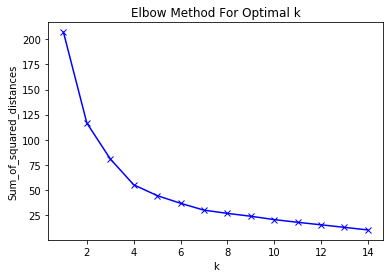

In [452]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [721]:
optimal_cluster=4
#states_data.drop(columns=['weather_cluster'], inplace=True)
states_data.insert(3,column='weather_cluster', value=pd.DataFrame(labels[optimal_cluster-1]))
states_data

,state,state_code,region,weather_cluster,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
0,Alabama,AL,South,1.0,1480.0,0.8,4.1,84.0,52.0,58.0,2641.0,99.0,17.1,86.419470
1,Arkansas,AR,South,1.0,1284.0,3.8,13.2,85.0,49.0,61.0,2771.0,123.0,15.8,74.793365
2,Connecticut,CT,Northeast,0.0,1279.0,20.1,102.9,79.0,52.0,56.0,2585.0,82.0,9.4,230.990937
5,Florida,FL,South,0.0,1385.0,0.0,0.0,87.0,57.0,66.0,2927.0,101.0,21.5,320.272950
6,Georgia,GA,South,1.0,1287.0,0.7,1.8,86.0,50.0,66.0,2986.0,112.0,17.5,119.665394
7,Kentucky,KY,South,0.0,1242.0,11.8,31.8,79.0,55.0,56.0,2514.0,93.0,13.1,79.535841
8,Louisiana,LA,South,0.0,1528.0,0.1,0.0,87.0,61.0,57.0,2649.0,101.0,19.1,210.489133
9,Massachusetts,MA,Northeast,0.0,1211.0,22.4,111.3,75.0,59.0,58.0,2634.0,98.0,8.8,285.895846
10,Maryland,MD,South,1.0,1131.0,9.6,51.3,77.0,52.0,57.0,2582.0,105.0,12.3,267.582460
11,Maine,ME,Northeast,1.0,1072.0,27.8,157.0,82.0,61.0,57.0,2513.0,101.0,5.0,320.398009


Let's visualize the resulting clusters.

In [710]:
address = 'United States of America'

geolocator = Nominatim(user_agent="usa_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of USA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of USA are 39.7837304, -100.4458825.


In [460]:
states_data.groupby('weather_cluster').mean()

,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
weather_cluster,,,,,,,,,,
0.0,1268.000,14.544444,66.877778,82.444444,55.444444,58.666667,2654.333333,99.666667,14.111111,202.990103
1.0,1242.125,10.875000,50.112500,81.625000,53.500000,58.875000,2652.875000,103.375000,12.662500,190.696816
2.0,1230.000,4.500000,21.600000,84.500000,54.000000,60.000000,2662.500000,104.500000,14.200000,441.282310
3.0,918.500,15.550000,79.100000,83.000000,51.000000,57.500000,2684.500000,112.500000,12.400000,175.338861


In [749]:
usa_geo = r'us-states.json' # geojson file

bins = [float(i) for i in list(range(0,5))]

# create a plain usa map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4, tiles='Mapbox Bright')

# generate choropleth map using the custer
folium.Choropleth(
    geo_data=usa_geo,
    name='choropleth',
    data=states_data,
    columns=['state', 'weather_cluster'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name='States With Similar Weather',
    bins=bins,
    reset=True
).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)


# display map       
map_clusters

In [478]:
target_cluster_num=states_data.loc[states_data['state']=='Alabama','weather_cluster'][0]
target_cluster=states_data[states_data['weather_cluster'] == target_cluster_num]
target_cluster

,state,state_code,region,weather_cluster,millimetres,days,centimetres,morning,afternoon,%_sun,total_hours,clear_days,avg_c,home_value
0,Alabama,AL,South,1.0,1480.0,0.8,4.1,84.0,52.0,58.0,2641.0,99.0,17.1,86.419470
1,Arkansas,AR,South,1.0,1284.0,3.8,13.2,85.0,49.0,61.0,2771.0,123.0,15.8,74.793365
6,Georgia,GA,South,1.0,1287.0,0.7,1.8,86.0,50.0,66.0,2986.0,112.0,17.5,119.665394
10,Maryland,MD,South,1.0,1131.0,9.6,51.3,77.0,52.0,57.0,2582.0,105.0,12.3,267.582460
11,Maine,ME,Northeast,1.0,1072.0,27.8,157.0,82.0,61.0,57.0,2513.0,101.0,5.0,320.398009
18,Pennsylvania,PA,Northeast,1.0,1089.0,19.4,71.6,77.0,54.0,58.0,2614.0,87.0,9.3,201.206808
19,Rhode Island,RI,Northeast,1.0,1218.0,18.7,85.9,78.0,57.0,58.0,2606.0,98.0,10.1,362.662507
21,Tennessee,TN,South,1.0,1376.0,6.2,16.0,84.0,53.0,56.0,2510.0,102.0,14.2,92.846516


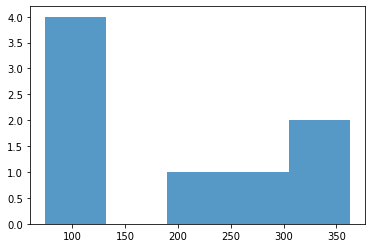

In [479]:
target_cluster['home_value'].hist(bins=5, grid=False, alpha=0.75)

In [640]:
selected_states=target_cluster.sort_values(by=['home_value']).head(4)[['state', 'state_code', 'region']].reset_index(drop=True)
selected_states

,state,state_code,region
0,Arkansas,AR,South
1,Alabama,AL,South
2,Tennessee,TN,South
3,Georgia,GA,South


In [641]:
#%%time

state_cities = pd.read_csv('uscities.csv', usecols=['city_ascii', 'state_name', 'lat', 'lng', 'population','density', 'ranking'])
state_cities.columns = fix_html_encoding(standardize_columns(state_cities.columns))

state_cities.rename(columns={'city_ascii':'city', 'state_name':'state'}, inplace=True)

#state_cities.dtypes
#state_cities[['lat', 'lng', 'population','density', 'ranking']] = state_cities[['lat', 'lng', 'population','density', 'ranking']].apply(pd.to_numeric, errors='coerce')
#state_cities.dtypes

print (state_cities.shape)
state_cities=state_cities.dropna()
print (state_cities.shape)

state_cities.head()

(28889, 7)
(28889, 7)


,city,state,lat,lng,population,density,ranking
0,South Creek,Washington,46.9994,-122.3921,2500.0,125.0,3
1,Roslyn,Washington,47.2507,-121.0989,947.0,84.0,3
2,Sprague,Washington,47.3048,-117.9713,441.0,163.0,3
3,Gig Harbor,Washington,47.3352,-122.5968,9507.0,622.0,3
4,Lake Cassidy,Washington,48.0639,-122.0920,3591.0,131.0,3


In [642]:
selected_states=selected_states.merge(state_cities, on='state', how='left')
selected_states.head()

,state,state_code,region,city,lat,lng,population,density,ranking
0,Arkansas,AR,South,McDougal,36.4365,-90.3907,171.0,177.0,3
1,Arkansas,AR,South,McAlmont,34.7926,-92.1959,1704.0,423.0,3
2,Arkansas,AR,South,Paris,35.2899,-93.7236,3020.0,275.0,3
3,Arkansas,AR,South,Crawfordsville,35.2267,-90.3241,467.0,322.0,3
4,Arkansas,AR,South,Gravette,36.4291,-94.3713,3304.0,83.0,3


In [643]:
selected_states.describe(include='all')

,state,state_code,region,city,lat,lng,population,density,ranking
count,2167,2167,2167,2167,2167.000000,2167.000000,2.167000e+03,2167.000000,2167.000000
unique,4,4,1,1932,NaN,NaN,NaN,NaN,NaN
top,Georgia,GA,South,Jasper,NaN,NaN,NaN,NaN,NaN
freq,620,620,2167,4,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,34.044797,-87.132023,1.094807e+04,224.308722,2.985233
std,NaN,NaN,NaN,NaN,1.618391,3.521011,1.212822e+05,242.638913,0.131627
min,NaN,NaN,NaN,NaN,30.252500,-94.588900,0.000000e+00,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,32.930050,-89.800450,3.775000e+02,72.500000,3.000000
50%,NaN,NaN,NaN,NaN,34.102600,-86.452900,1.166000e+03,155.000000,3.000000
75%,NaN,NaN,NaN,NaN,35.381400,-84.349500,3.916500e+03,290.000000,3.000000


In [644]:
selected_states[selected_states['ranking'].astype(str).str.contains('1|2')].describe(include='all')

,state,state_code,region,city,lat,lng,population,density,ranking
count,29,29,29,29,29.000000,29.000000,2.900000e+01,29.000000,29.000000
unique,4,4,1,29,NaN,NaN,NaN,NaN,NaN
top,Georgia,GA,South,Johnson City,NaN,NaN,NaN,NaN,NaN
freq,13,13,29,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,34.124283,-85.801162,4.595933e+05,827.068966,1.896552
std,NaN,NaN,NaN,NaN,1.628433,3.363570,9.577405e+05,643.996780,0.309934
min,NaN,NaN,NaN,NaN,30.678200,-94.369500,1.101000e+03,236.000000,1.000000
25%,NaN,NaN,NaN,NaN,33.234800,-86.798700,1.265890e+05,481.000000,2.000000
50%,NaN,NaN,NaN,NaN,33.936600,-84.422500,1.828490e+05,594.000000,2.000000
75%,NaN,NaN,NaN,NaN,35.349300,-83.697400,3.893830e+05,793.000000,2.000000


In [645]:
selected_states=selected_states[selected_states['ranking'].astype(str).str.contains('1|2')]
selected_states

,state,state_code,region,city,lat,lng,population,density,ranking
105,Arkansas,AR,South,Fort Smith,35.3493,-94.3695,125562.0,537.0,2
128,Arkansas,AR,South,Little Rock,34.7255,-92.3580,442699.0,643.0,2
397,Arkansas,AR,South,Fayetteville,36.0713,-94.1660,341890.0,609.0,2
640,Alabama,AL,South,Birmingham,33.5277,-86.7987,744189.0,556.0,2
641,Alabama,AL,South,Montgomery,32.3473,-86.2666,255908.0,481.0,2
725,Alabama,AL,South,Tuscaloosa,33.2348,-87.5266,154204.0,627.0,2
885,Alabama,AL,South,Mobile,30.6782,-88.1163,318084.0,526.0,2
1068,Alabama,AL,South,Huntsville,34.6988,-86.6412,309716.0,350.0,2
1169,Tennessee,TN,South,Kingsport,36.5224,-82.5452,118001.0,393.0,2
1190,Tennessee,TN,South,Clarksville,36.5696,-87.3428,182849.0,603.0,2


In [647]:
def get_rec(state, count, df):
    return df[df['state']==state].sort_values(by=['population', 'density'], ascending=False).head(count)

sel_cities=pd.DataFrame()
min_cities=selected_states.groupby('state').count()[['state_code']].min()[0]

for st in selected_states['state'].unique():
    temp=get_rec(st, min_cities, selected_states)
    sel_cities=sel_cities.append(temp, ignore_index=True)

sel_cities.describe(include='all')

,state,state_code,region,city,lat,lng,population,density,ranking
count,12,12,12,12,12.000000,12.000000,1.200000e+01,12.000000,12.000000
unique,4,4,1,12,NaN,NaN,NaN,NaN,NaN
top,Georgia,AR,South,Savannah,NaN,NaN,NaN,NaN,NaN
freq,3,3,12,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,34.287617,-87.569392,9.092602e+05,622.166667,1.750000
std,NaN,NaN,NaN,NaN,1.693629,4.420410,1.393901e+06,280.852868,0.452267
min,NaN,NaN,NaN,NaN,30.678200,-94.369500,1.255620e+05,251.000000,1.000000
25%,NaN,NaN,NaN,NaN,33.486900,-90.572475,3.159920e+05,534.250000,1.750000
50%,NaN,NaN,NaN,NaN,34.712150,-86.791500,4.160410e+05,550.000000,2.000000
75%,NaN,NaN,NaN,NaN,35.504275,-84.304275,8.253600e+05,665.250000,2.000000


## Part 3

### Explore data and visualize neighboorhoods

Create a map of Toronto city with selected neighborhoods superimposed on top using **Folium** visualization library. 

In [651]:
# create map of Toronto using latitude and longitude values
map_usa = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng, label in zip(sel_cities['lat'], sel_cities['lng'], sel_cities['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa)  
    
map_usa

### Explore selected boroughs

Let's use the Foursquare API to explore the neighborhoods and segment them.

In [661]:
# Define Foursquare Credentials, Version and Limits.
CLIENT_ID = '3BCVAXKBYMT2WBM10IJUSYVZUVSU15GUZLHLNS4NKPFSBLEM' # your Foursquare ID
CLIENT_SECRET = 'UMX4R2I5HYBTHFYSSTQPG2H1YPXPQ5IJ4V1FXLZPV5BQYE3R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 10000 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3BCVAXKBYMT2WBM10IJUSYVZUVSU15GUZLHLNS4NKPFSBLEM
CLIENT_SECRET:UMX4R2I5HYBTHFYSSTQPG2H1YPXPQ5IJ4V1FXLZPV5BQYE3R


Let's borrow the function from New York city lab to explore all the neighborhoods in selected boroughs.

In [662]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's explore all near-by venues and save them in new DataFrame.

In [663]:
usa_venues = getNearbyVenues(names=sel_cities['city'],
                                   latitudes=sel_cities['lat'],
                                   longitudes=sel_cities['lng']
                                  )


Little Rock
Fayetteville
Fort Smith
Birmingham
Mobile
Huntsville
Nashville
Memphis
Knoxville
Atlanta
Augusta
Savannah


Let's check the size of the resulting dataframe and peek in to the contents.

In [664]:
print(usa_venues.shape)
usa_venues.head()

(1191, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Little Rock,34.7255,-92.358,Mike's Cafe,34.718804,-92.334950,Asian Restaurant
1,Little Rock,34.7255,-92.358,Big Orange,34.753050,-92.339492,Burger Joint
2,Little Rock,34.7255,-92.358,Chick-fil-A,34.751925,-92.343623,Fast Food Restaurant
3,Little Rock,34.7255,-92.358,Panera Bread,34.750249,-92.342155,Bakery
4,Little Rock,34.7255,-92.358,Texas Roadhouse,34.732619,-92.395466,Steakhouse


And number of venues  returned for each neighborhood...

In [665]:
usa_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Atlanta,100,100,100,100,100,100
Augusta,100,100,100,100,100,100
Birmingham,100,100,100,100,100,100
Fayetteville,91,91,91,91,91,91
Fort Smith,100,100,100,100,100,100
Huntsville,100,100,100,100,100,100
Knoxville,100,100,100,100,100,100
Little Rock,100,100,100,100,100,100
Memphis,100,100,100,100,100,100


How many unique categories can be curated from all the returned venues?

In [666]:
print('There are {} uniques categories.'.format(len(usa_venues['Venue Category'].unique())))

There are 200 uniques categories.


In [668]:
health_fitness='Sport|Pool|Park|Gym|Massage|Basketball|Spa|Playground|Stadium|Fitness|Golf|Football|Bowling|Court|Gymnastics|Hockey|Baseball|Field'
usa_venues[usa_venues['Venue Category'].str.contains(health_fitness)].groupby('Venue Category').count()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Baseball Field,3,3,3,3,3,3
Baseball Stadium,5,5,5,5,5,5
Basketball Stadium,2,2,2,2,2,2
Bowling Alley,2,2,2,2,2,2
Climbing Gym,1,1,1,1,1,1
College Basketball Court,1,1,1,1,1,1
College Football Field,1,1,1,1,1,1
College Gym,1,1,1,1,1,1
Field,1,1,1,1,1,1


In [671]:
usa_venues=usa_venues[usa_venues['Venue Category'].str.contains(health_fitness) & ~usa_venues['Venue Category'].str.contains('Food', 'Spanish ')]
usa_venues

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
48,Little Rock,34.7255,-92.3580,Academy Sports + Outdoors,34.755431,-92.402417,Sporting Goods Shop
60,Little Rock,34.7255,-92.3580,Riverfront Park,34.748710,-92.267797,Park
64,Little Rock,34.7255,-92.3580,War Memorial Stadium / AT&T Field,34.750163,-92.329527,Football Stadium
65,Little Rock,34.7255,-92.3580,Dickey-Stephens Park,34.755755,-92.272813,Baseball Stadium
66,Little Rock,34.7255,-92.3580,Bass Pro Shops,34.658619,-92.409142,Sporting Goods Shop
67,Little Rock,34.7255,-92.3580,Burns Park Soccer Complex,34.795409,-92.325389,Soccer Field
77,Little Rock,34.7255,-92.3580,MacArthur Park,34.739232,-92.268172,Park
100,Fayetteville,36.0713,-94.1660,Wilson Park,36.073040,-94.164657,Park
107,Fayetteville,36.0713,-94.1660,Donald W Reynolds Razorback Stadium,36.067851,-94.178796,College Football Field
112,Fayetteville,36.0713,-94.1660,Bud Walton Arena,36.061405,-94.177967,College Basketball Court


### Analyze each neighborhood

Let's prepare data for the clustering.

In [672]:
# One hot encoding
usa_onehot = pd.get_dummies(usa_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
usa_onehot['City'] = usa_venues['City'] 

# Move neighborhood column as the first column
col='City'
temp = usa_onehot[col]
usa_onehot.drop(labels=[col], axis=1,inplace = True)
usa_onehot.insert(0, col, temp)

usa_onehot.head()

,City,Baseball Field,Baseball Stadium,Basketball Stadium,Bowling Alley,Climbing Gym,College Basketball Court,College Football Field,College Gym,Field,Food Court,Football Stadium,Golf Course,Gym,Gym / Fitness Center,Hockey Arena,Park,Playground,Skate Park,Soccer Field,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Tennis Court
48,Little Rock,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
60,Little Rock,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
64,Little Rock,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
65,Little Rock,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,Little Rock,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Let's explore the size of the DataFrame.

In [674]:
usa_onehot.shape

(82, 25)

Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category and create a new DataFrame from it.

In [687]:
usa_grouped = usa_onehot.groupby('City').sum().reset_index()
usa_grouped

,City,Baseball Field,Baseball Stadium,Basketball Stadium,Bowling Alley,Climbing Gym,College Basketball Court,College Football Field,College Gym,Field,Food Court,Football Stadium,Golf Course,Gym,Gym / Fitness Center,Hockey Arena,Park,Playground,Skate Park,Soccer Field,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Tennis Court
0,Atlanta,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,4,0,0,0,1,1,0,0,0
1,Augusta,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,2,0,0,0,0,0,0,0,0
2,Birmingham,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1,0,0,0,0,1,0,0
3,Fayetteville,2,0,0,0,0,1,1,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,1,0
4,Fort Smith,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2,0,0
5,Huntsville,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,2,1,0
6,Knoxville,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0
7,Little Rock,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,1,0,0,2,0,0
8,Memphis,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0
9,Mobile,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1


In [688]:
usa_grouped['Total']=usa_grouped.sum(axis = 1, skipna = True)
usa_grouped

,City,Baseball Field,Baseball Stadium,Basketball Stadium,Bowling Alley,Climbing Gym,College Basketball Court,College Football Field,College Gym,Field,Food Court,Football Stadium,Golf Course,Gym,Gym / Fitness Center,Hockey Arena,Park,Playground,Skate Park,Soccer Field,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Tennis Court,Total
0,Atlanta,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,4,0,0,0,1,1,0,0,0,10
1,Augusta,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,2,0,0,0,0,0,0,0,0,6
2,Birmingham,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1,0,0,0,0,1,0,0,7
3,Fayetteville,2,0,0,0,0,1,1,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,1,0,10
4,Fort Smith,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2,0,0,4
5,Huntsville,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,2,1,0,6
6,Knoxville,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,7
7,Little Rock,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,1,0,0,2,0,0,7
8,Memphis,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,6
9,Mobile,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,4


Let's confirm the size of the resulting DataFrame.

In [696]:
usa_grouped=usa_grouped.sort_values('Total', ascending=False)[['City', 'Total']].head(3)
usa_grouped

,City,Total
10,Nashville,12
0,Atlanta,10
3,Fayetteville,10


In [709]:
usa_grouped.merge(selected_states, left_on='City', right_on='city', how='left')[['state', 'state_code', 'region', 'city', 'lat', 'lng']]


,state,state_code,region,city,lat,lng
0,Tennessee,TN,South,Nashville,36.1715,-86.7843
1,Georgia,GA,South,Atlanta,33.7627,-84.4225
2,Arkansas,AR,South,Fayetteville,36.0713,-94.1660


Thank you for evaluating the assignment.